In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

In [7]:
# === Load Skyline data ===
skyline_file = "C:/Users/49152/Desktop/Repositories/Multiomics_study/Fluxomics/Skyline_trial/Example_output_from_Skyline/Transition_Results.csv"   # <-- replace with your Skyline file
sky = pd.read_csv(skyline_file)

# === Map Skyline isotopologues to TraceFinder column names ===
def map_isotopologue(label):
    if label.startswith("[M-H]"):
        return "No Label"
    elif label.startswith("[MC13-H]"):
        return "1C13"
    elif label.startswith("[M2C13-H]"):
        return "2C13"
    elif label.startswith("[M3C13-H]"):
        return "3C13"
    elif label.startswith("[M4C13-H]"):
        return "4C13"
    elif label.startswith("[M5C13-H]"):
        return "5C13"
    elif label.startswith("[M6C13-H]"):
        return "6C13"
    elif label.startswith("[M7C13-H]"):
        return "7C13"
    elif label.startswith("[M8C13-H]"):
        return "8C13"
    elif label.startswith("[M9C13-H]"):
        return "9C13"
    else:
        return None

sky["Isotopologue"] = sky["Precursor Adduct"].apply(map_isotopologue)

# Compute S/N ratio
sky["SNR"] = sky["Area"] / (sky["Background"] + 1)
sky = sky[["Molecule", "Replicate Name", "Isotopologue", "Area", "SNR"]]
sky

In [9]:
sky

,Molecule,Replicate Name,Isotopologue,Area,SNR
0,Pyruvate,250509_MHO06AI_CoA_1,No Label,11440586,11.196678
1,Pyruvate,250509_MHO06AI_CoA_2,No Label,64616940,12.529933
2,Pyruvate,250509_MHO06AI_CoA_3,No Label,8951289,7.874824
3,Pyruvate,250509_MHO06AI_CoA_4,No Label,18313592,11.342965
4,Pyruvate,250509_MHO06AI_CoA_5,No Label,1743339,0.362980
...,...,...,...,...,...
1689,AcetylCoA,250509_MHO06AI_CoA_116,9C13,472,472.000000
1690,AcetylCoA,250509_MHO06AI_CoA_117,9C13,655,655.000000
1691,AcetylCoA,250509_MHO06AI_CoA_118,9C13,658,658.000000
1692,AcetylCoA,250509_MHO06AI_CoA_119,9C13,110,110.000000


In [15]:
# === Load and combine multiple TraceFinder files ===
tracefinder_folder = "C:/Users/49152/Desktop/Repositories/Multiomics_study/Fluxomics/Skyline_trial/Example_output_from_TraceFinder/"   # <-- folder where all TF CSVs are stored
all_tf_files = glob.glob(os.path.join(tracefinder_folder, "*.csv"))

tf_list = []
for f in all_tf_files:
    tf = pd.read_csv(f)
    # Keep long format
    tf_melt = tf.melt(
        id_vars=["filename", "compound"],
        value_vars=[c for c in tf.columns if c not in ["index", "filename", "compound"]],
        var_name="Isotopologue",
        value_name="TF_Area"
    )
    tf_list.append(tf_melt)

# Concatenate all TF data
tf_all = pd.concat(tf_list, ignore_index=True)

# ✅ Keep only rows where filename matches Skyline Replicate Name
valid_replicates = set(sky["Replicate Name"].unique())
tf_all = tf_all[tf_all["filename"].isin(valid_replicates)].copy()

tf_all

,filename,compound,Isotopologue,TF_Area
0,250509_MHO06AI_CoA_1,AcetylCoA,1C13,647766.2634
1,250509_MHO06AI_CoA_10,AcetylCoA,1C13,380299.2678
2,250509_MHO06AI_CoA_100,AcetylCoA,1C13,553710.8393
3,250509_MHO06AI_CoA_101,AcetylCoA,1C13,608841.3063
4,250509_MHO06AI_CoA_102,AcetylCoA,1C13,613058.3511
...,...,...,...,...
2352,250509_MHO06AI_CoA_95,Pyruvate,No Label,328654.3865
2353,250509_MHO06AI_CoA_96,Pyruvate,No Label,135062.1596
2354,250509_MHO06AI_CoA_97,Pyruvate,No Label,598627.1157
2355,250509_MHO06AI_CoA_98,Pyruvate,No Label,522322.5156


In [17]:
# === Merge Skyline and TraceFinder ===
merged = pd.merge(
    sky,
    tf_all,
    left_on=["Molecule", "Replicate Name", "Isotopologue"],
    right_on=["compound", "filename", "Isotopologue"],
    how="inner"
)
merged

,Molecule,Replicate Name,Isotopologue,Area,SNR,filename,compound,TF_Area
0,Pyruvate,250509_MHO06AI_CoA_1,No Label,11440586,11.196678,250509_MHO06AI_CoA_1,Pyruvate,1.149375e+07
1,Pyruvate,250509_MHO06AI_CoA_2,No Label,64616940,12.529933,250509_MHO06AI_CoA_2,Pyruvate,6.392254e+07
2,Pyruvate,250509_MHO06AI_CoA_3,No Label,8951289,7.874824,250509_MHO06AI_CoA_3,Pyruvate,9.260520e+06
3,Pyruvate,250509_MHO06AI_CoA_4,No Label,18313592,11.342965,250509_MHO06AI_CoA_4,Pyruvate,1.886325e+07
4,Pyruvate,250509_MHO06AI_CoA_5,No Label,1743339,0.362980,250509_MHO06AI_CoA_5,Pyruvate,1.045811e+07
...,...,...,...,...,...,...,...,...
1689,AcetylCoA,250509_MHO06AI_CoA_116,9C13,472,472.000000,250509_MHO06AI_CoA_116,AcetylCoA,NaN
1690,AcetylCoA,250509_MHO06AI_CoA_117,9C13,655,655.000000,250509_MHO06AI_CoA_117,AcetylCoA,1.064783e+03
1691,AcetylCoA,250509_MHO06AI_CoA_118,9C13,658,658.000000,250509_MHO06AI_CoA_118,AcetylCoA,NaN
1692,AcetylCoA,250509_MHO06AI_CoA_119,9C13,110,110.000000,250509_MHO06AI_CoA_119,AcetylCoA,1.413236e+03


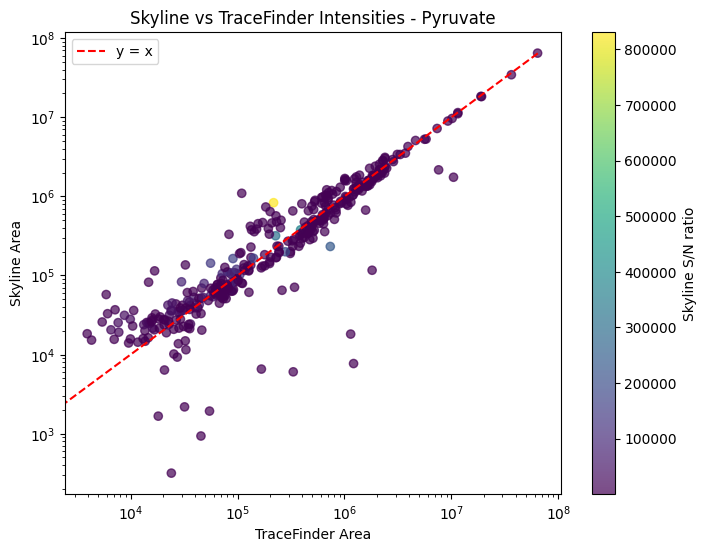

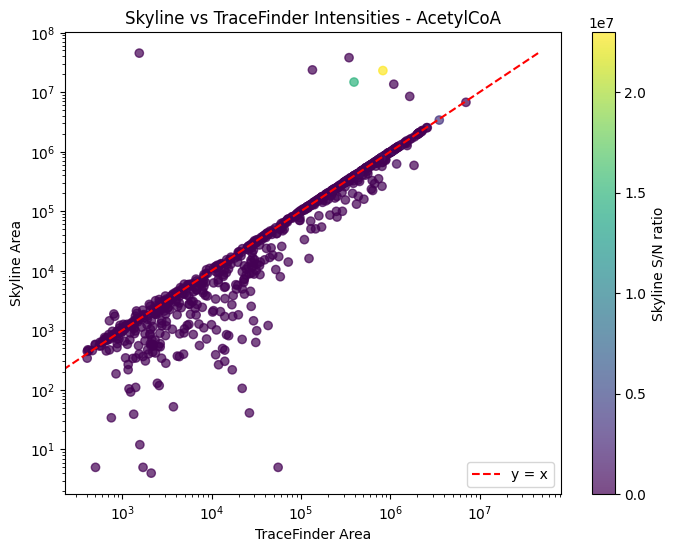

In [23]:
# === Visualization ===
for metabolite in merged["Molecule"].unique():
    subset = merged[merged["Molecule"] == metabolite]
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
    subset["TF_Area"], subset["Area"],
    c=subset["SNR"], cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="Skyline S/N ratio")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("TraceFinder Area")
    plt.ylabel("Skyline Area")
    plt.title(f"Skyline vs TraceFinder Intensities - {metabolite}")
    
    # ✅ Proper diagonal reference line for log-log plots
    lims = [
    min(subset["TF_Area"].min(), subset["Area"].min()),
    max(subset["TF_Area"].max(), subset["Area"].max())]
    plt.plot(lims, lims, "r--", label="y = x")
    plt.legend()
    plt.show()